# Iterating through all patients in all years to find peep>5

In [1]:
import pandas as pd
from datetime import datetime
import os
import pickle
from datetime import timedelta
from datetime import datetime
from datetime import date
from datetime import time
from dateutil.relativedelta import relativedelta

import pandas as pd
import numpy as np
import os

import json

import sys
from scipy.io import loadmat

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
import matplotlib.ticker as plticker

import seaborn as sns


import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PhysioMC/') # add this line so Data and data are visible in this file

# from PatchWand import *
from filters import *
from setting import *
# from preprocessing import *
from ECG_module import *
from dataIO import *
from stage1_PPG_analysis import *

from importlib import reload
%load_ext autoreload
%autoreload 2

In [32]:
selected_id = 10

In [3]:
%pwd

'/labs/kamaleswaranlab/Sepsis3_062321/mchan_analysis/disparities_O2/repo/stage1_PPG_analysis'

# get PPG data

## os.listdir(inputdir) = 
## ['A071-0512777549',
## 'A063-0482186017',
## 'A113-0520303111', ...]

## os.listdir(inputdir_rec) = 
## ['A058-0502749430_0028d.mat',
##  'A058-0502749430.almth',
##  'A058-0502749430_0013.mat',
##  'A058-0502749430_0013.hea',...]

In [4]:
outputdir = '../../data/stage1/'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

In [5]:
with open('recording_lookup.json') as json_file:
    recording_lookup = json.load(json_file)


In [6]:

homedir = os.path.expanduser('~')+'/'

# inputdir = homedir+'kamaleswaranlab/Sepsis3_062321/Files_cp_sftp_6_30_21/Files_cp_6_30_21/'
# this is where all waveform data are stored
inputdir = '/labs/kamaleswaranlab/Sepsis3_062321/Files_cp_sftp_6_30_21/Files_cp_6_30_21/'

# yes
# rec_id = 'A058-0502749430'

# no
# rec_id = 'A030-0497283634'
# rec_id = 'A097-0427935662'
# rec_id = 'A085-0500344504'


# # check the header files in here
# for rec_file in os.listdir(inputdir+rec_id):
#     if 'hea' in rec_file:
#         print(rec_file)

# get the header file

In [33]:
def header_extract(header):
    Fs = int(header[0].split(' ')[2])
    N_sigs = int(header[0].split(' ')[1])
    start_time = header[0].split(' ')[4]
    date =  header[0].split(' ')[5].split('\n')[0] # TODO: check if this is birthday
    N_samples = int(header[0].split(' ')[3])
    t_dur = N_samples/Fs/60/60 # hr
    
    # sig_names = []
    unit_dict = {}
    gain_dict = {}
    for h in header[1:]:
        sig_name = h.split(' ')[-1].split('\n')[0]
        
        unit = h.split(' ')[2].split('/')[1]
        if unit == '':
            unit = 'a.u.'
        unit_dict[sig_name] = unit
        
        gain = h.split(' ')[2].split('/')[0]
        gain_dict[sig_name] = float(gain)
        # sig_names.append( h.split(' ')[-1].split('\n')[0] )
        
    
    header_dict = {
        'Fs': Fs,
        'N_sigs': N_sigs,
        'start_time': start_time,
        'date': date,
        'N_samples': N_samples,
        't_dur(hr)': t_dur,
        'unit_dict': unit_dict,
        'gain_dict': gain_dict,
    }
    return header_dict

In [34]:

rec_id = list(recording_lookup.keys())[selected_id]

bed_id = rec_id.split('-')[0]
subject_id = rec_id.split('-')[1]

header_id = recording_lookup[rec_id]
header_name = rec_id+'_{}.hea'.format(header_id)

# get recording directory
inputdir_rec = inputdir + rec_id + '/'
# print(os.listdir(inputdir_rec))


# get header file directory
headerdir = inputdir_rec + header_name
print(headerdir)

# load header file
with open(headerdir, 'r') as f:
    header = f.readlines()

    
header_dict = header_extract(header)
header_dict

/labs/kamaleswaranlab/Sepsis3_062321/Files_cp_sftp_6_30_21/Files_cp_6_30_21/A051-0487285205/A051-0487285205_0008.hea


{'Fs': 240,
 'N_sigs': 14,
 'start_time': '06:58:47.000',
 'date': '19/02/1987',
 'N_samples': 6912000,
 't_dur(hr)': 8.0,
 'unit_dict': {'I': 'mV',
  'II': 'mV',
  'III': 'mV',
  'V': 'mV',
  'SPO2': 'a.u.',
  'RR': 'a.u.',
  'AR1': 'mmHg',
  'SP3': 'mmHg',
  'ICP3': 'mmHg',
  'ICP1': 'mmHg',
  'AR2': 'mmHg',
  'CO2': 'mmHg',
  'SP1': 'mmHg',
  'ICP2': 'mmHg'},
 'gain_dict': {'I': 409.836,
  'II': 409.836,
  'III': 409.836,
  'V': 409.836,
  'SPO2': 200.0,
  'RR': 200.0,
  'AR1': 5.0,
  'SP3': 5.0,
  'ICP3': 5.0,
  'ICP1': 5.0,
  'AR2': 5.0,
  'CO2': 4.0,
  'SP1': 5.0,
  'ICP2': 5.0}}

In [35]:
header

['A051-0487285205_0008 14 240 6912000 06:58:47.000 19/02/1987\n',
 'A051-0487285205_0008.mat 16+24 409.836/mV 16 0 -58 0 0 I\n',
 'A051-0487285205_0008.mat 16+24 409.836/mV 16 0 -136 0 0 II\n',
 'A051-0487285205_0008.mat 16+24 409.836/mV 16 0 -73 0 0 III\n',
 'A051-0487285205_0008.mat 16+24 409.836/mV 16 0 -191 0 0 V\n',
 'A051-0487285205_0008.mat 16+24 200/ 16 0 540 0 0 SPO2\n',
 'A051-0487285205_0008.mat 16+24 200/ 16 0 123 0 0 RR\n',
 'A051-0487285205_0008.mat 16+24 5/mmHg 16 0 352 0 0 AR1\n',
 'A051-0487285205_0008.mat 16+24 5/mmHg 16 0 -32768 0 0 SP3\n',
 'A051-0487285205_0008.mat 16+24 5/mmHg 16 0 -32768 0 0 ICP3\n',
 'A051-0487285205_0008.mat 16+24 5/mmHg 16 0 -32768 0 0 ICP1\n',
 'A051-0487285205_0008.mat 16+24 5/mmHg 16 0 -32768 0 0 AR2\n',
 'A051-0487285205_0008.mat 16+24 4/mmHg 16 0 133 0 0 CO2\n',
 'A051-0487285205_0008.mat 16+24 5/mmHg 16 0 -32768 0 0 SP1\n',
 'A051-0487285205_0008.mat 16+24 5/mmHg 16 0 37 0 0 ICP2\n']

In [36]:
# recording_lookup

# get raw waveform data

In [37]:
# for rec_file in os.listdir(inputdir+rec_id):
#     if 'mat' in rec_file:
#         print(rec_file)

In [38]:
# for rec_file in os.listdir(inputdir+rec_id):
#     if 'd.mat' in rec_file:
#         if '0nd.mat' in rec_file:
#             continue
#         # print(sub_file)
#         keep_file = rec_file

In [39]:
# rec_file

# choose a sub_id, and choose one of his/her 8hr segments

In [40]:
# # keep_file = sub_id+'_0001d.mat'
# keep_file = rec_id+'_0004d.mat' # 0004d has all info, 0004 only has waveforms (matrix)

# # sub_id

In [41]:
recording_name = rec_id+'_'+header_id



In [42]:
waveformdir = inputdir+rec_id+'/' +rec_id+'_'+header_id+'.mat'
data = loadmat(waveformdir)['val']


In [43]:
# # file_d_name = keep_file

# # file_d_dir = inputdir_rec+file_d_name

# waveformdir = inputdir+rec_id+'/' +rec_id+'_'+header_id+'d.mat'

# data_d = loadmat(waveformdir)
# print(data_d['wlabel'])
# wlabel = data_d['wlabel']

# sig_names = []
# for label in wlabel:
#     sig_names.append(label.split(' ')[0])

# data_d

In [44]:
# plt.plot(data_d['val'][0,:5000])

In [45]:
# file_name = file_d_name.replace("d.mat", ".mat")
# # file_name = 'A071-0512777549_0000.mat'

# file_dir = inputdir_rec+file_name

# data = loadmat(file_dir)['val']


In [46]:
# data.shape, wgain.squeeze()

# store the data in dataframe

In [47]:
unit_dict = header_dict['unit_dict']
gain_dict = header_dict['gain_dict']

Fs = header_dict['Fs']

In [48]:
header_dict

{'Fs': 240,
 'N_sigs': 14,
 'start_time': '06:58:47.000',
 'date': '19/02/1987',
 'N_samples': 6912000,
 't_dur(hr)': 8.0,
 'unit_dict': {'I': 'mV',
  'II': 'mV',
  'III': 'mV',
  'V': 'mV',
  'SPO2': 'a.u.',
  'RR': 'a.u.',
  'AR1': 'mmHg',
  'SP3': 'mmHg',
  'ICP3': 'mmHg',
  'ICP1': 'mmHg',
  'AR2': 'mmHg',
  'CO2': 'mmHg',
  'SP1': 'mmHg',
  'ICP2': 'mmHg'},
 'gain_dict': {'I': 409.836,
  'II': 409.836,
  'III': 409.836,
  'V': 409.836,
  'SPO2': 200.0,
  'RR': 200.0,
  'AR1': 5.0,
  'SP3': 5.0,
  'ICP3': 5.0,
  'ICP1': 5.0,
  'AR2': 5.0,
  'CO2': 4.0,
  'SP1': 5.0,
  'ICP2': 5.0}}

In [49]:
raw_dict = {}
# wgain = data_d['wgain'].squeeze()

for i, sig_name in enumerate(gain_dict.keys()):
    raw_dict[sig_name] = data[i, :]/gain_dict[sig_name]

In [50]:

df = pd.DataFrame(raw_dict)

In [51]:
df

,I,II,III,V,SPO2,RR,AR1,SP3,ICP3,ICP1,AR2,CO2,SP1,ICP2
0,-0.14152,-0.33184,-0.17812,-0.46604,2.700,0.615,70.4,-6553.6,-6553.6,-6553.6,-6553.6,33.25,-6553.6,7.4
1,-0.10980,-0.19520,-0.07564,-0.22204,2.660,0.615,70.2,-6553.6,-6553.6,-6553.6,-6553.6,33.25,-6553.6,7.4
2,-0.09516,-0.10980,-0.00488,-0.09272,2.660,0.615,70.0,-6553.6,-6553.6,-6553.6,-6553.6,33.25,-6553.6,7.4
3,-0.07564,-0.08052,0.00976,-0.05124,2.625,0.615,69.8,-6553.6,-6553.6,-6553.6,-6553.6,33.25,-6553.6,7.4
4,-0.05124,-0.07564,-0.00976,-0.04880,2.580,0.660,69.6,-6553.6,-6553.6,-6553.6,-6553.6,33.25,-6553.6,7.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6911995,0.07076,0.31476,0.25132,-0.19764,3.040,-1.225,126.8,-6553.6,-6553.6,-6553.6,-6553.6,0.25,-6553.6,7.8
6911996,0.06344,0.29036,0.22692,-0.18544,3.375,-1.175,120.2,-6553.6,-6553.6,-6553.6,-6553.6,0.25,-6553.6,7.8
6911997,0.05612,0.25620,0.19764,-0.17080,3.710,-1.175,113.6,-6553.6,-6553.6,-6553.6,-6553.6,0.25,-6553.6,7.8
6911998,0.04880,0.22692,0.17568,-0.15372,3.710,-1.175,106.8,-6553.6,-6553.6,-6553.6,-6553.6,0.25,-6553.6,7.8


In [52]:
t_arr = np.arange(df.shape[0])/Fs

df['time'] = t_arr
df['time'] = df['time']-df['time'].values[0]

t_dur = df.shape[0]/Fs
print('t_dur: {:.2f}s'.format(t_dur))

t_dur: 28800.00s


In [53]:
# '{}'.format(unit_dict[sig_name])

In [54]:
# plotted_sigs
# sig_name.split(' ')[0]

In [55]:
plotted_sigs = list(unit_dict.keys())

for sig_name in plotted_sigs:
    
    if 'I' == sig_name or 'II' == sig_name or 'III' == sig_name or 'V' == sig_name:
        sig_title = 'ECG (lead {})'.format(sig_name)+ '\n({})'.format(unit_dict[sig_name])
    elif 'RR' == sig_name:
        sig_title = 'RR'+ '\n({})'.format('a.u.')
    elif 'SPO2' == sig_name:
        sig_title = 'PPG'+ '\n({})'.format('a.u.')
    elif 'AR1' == sig_name:
        sig_title = 'AR1'+ '\n({})'.format(unit_dict[sig_name])
    elif 'CVP3' == sig_name:
        sig_title = 'CVP3'+ '\n({})'.format(unit_dict[sig_name])
    elif 'CO2' == sig_name:
        sig_title = 'CO2'+ '\n({})'.format(unit_dict[sig_name])
    else:
        sig_title = 'a.u.'
        
    print(sig_name, sig_title)

I ECG (lead I)
(mV)
II ECG (lead II)
(mV)
III ECG (lead III)
(mV)
V ECG (lead V)
(mV)
SPO2 PPG
(a.u.)
RR RR
(a.u.)
AR1 AR1
(mmHg)
SP3 a.u.
ICP3 a.u.
ICP1 a.u.
AR2 a.u.
CO2 CO2
(mmHg)
SP1 a.u.
ICP2 a.u.


In [56]:
# def plot_all_sync(df, subject_id, plotted_sigs, plt_scale=0.3, fig_name=None, outputdir=None, show_plot=False):

#     # if plotted_sigs is None:
#     #     plotted_sigs = PLOTTED_SIGS

#     #     subject_id = df['subject_id'].unique()[0]

#     t_start = 100
#     t_end = 200

#     df_seg = df[(df['time']>=t_start) & (df['time']<=t_end)].copy()

#     t_arr = df_seg['time'].values
#     #     t_arr = t_arr - t_arr[0]

#     t_start = t_arr[0]
#     t_end = t_arr[-1]

#     t_dur = t_arr[-1] - t_arr[0]
#     plt_scale = 0.5

#     fig, axes = plt.subplots(len(plotted_sigs), 1, figsize=(25,len(plotted_sigs)), gridspec_kw = {'wspace':0, 'hspace':0}, dpi=80)

#     # TODO: make a plot dict
#     fontsize = 20*plt_scale
#     linewidth = 2
#     alpha = 0.8

#     for i, ax in enumerate(axes):
#         # condition grid
#         ax.grid('on', linestyle='--')
#         # no x ticks except for the bottom ax
#         if i<len(axes)-1:
#             ax.set_xticklabels([])
#         # add y ticks to all axes
#         ax.tick_params(axis='y', which='both', labelsize=20)

#         sig_name = plotted_sigs[i]
#         sig_plt = df_seg[sig_name].values

#         # if sig_name in sync_color_dict.keys():
#         #     color = color_dict[sync_color_dict[sig_name]]
#         # else:
#         #     color = random_colors[i]
#         ax.plot(t_arr, sig_plt, alpha=alpha ,zorder=1, linewidth=linewidth)
#         ax.set_xlim(t_start, t_end) # remove the weird white space at the beg and end of the plot


#     #     # remove some borders (top and right)
#     #     ax.spines['right'].set_visible(False)
#     #     if i==0:
#     #         ax.spines['top'].set_visible(False)

#     #     # add y label, indicate their unit
#         if 'I' == sig_name or 'II' == sig_name or 'III' == sig_name or 'V' == sig_name:
#             sig_title = 'ECG (lead {})'.format(sig_name)+ '\n({})'.format(unit_dict[sig_name])
#         elif 'RR' == sig_name:
#             sig_title = 'RR'+ '\n({})'.format('a.u.')
#         elif 'SPO2' == sig_name:
#             sig_title = 'PPG'+ '\n({})'.format('a.u.')
#         elif 'AR1' == sig_name:
#             sig_title = 'AR1'+ '\n({})'.format(unit_dict[sig_name])
#         elif 'CVP3' == sig_name:
#             sig_title = 'CVP3'+ '\n({})'.format(unit_dict[sig_name])
#         elif 'CO2' == sig_name:
#             sig_title = 'CO2'+ '\n({})'.format(unit_dict[sig_name])
#         else:
#             sig_title = 'a.u.'



#         ax.set_ylabel(sig_title, fontsize=fontsize,rotation = 0,  va='center', ha='center',  labelpad=100)

#         # set tick font size
#         ax.tick_params(axis='both', which='major', labelsize=fontsize*0.8)


#     #     # do this so there's no weird white space on top and bottom of each ax
#     #     y_min, y_max = ax.get_ylim()
#     #     ax.set_ylim(y_min, y_max)




#     # ax.set_xlabel('time (sec)', fontsize=fontsize)
#     # fig.subplots_adjust(wspace=0, hspace=0)
    
#     fig.tight_layout()

#     if fig_name is None:
#         fig_name = 'All_sub{}'.format(subject_id)
#     else:
#         fig_name = fig_name + '_sub{}'.format(subject_id)

#     if outputdir is not None:
#         if not os.path.exists(outputdir):
#             os.makedirs(outputdir)
#         fig.savefig(outputdir + fig_name, bbox_inches='tight', transparent=False)

#     if show_plot == False:
#         plt.close(fig)
#         pyplot.close(fig)
#         plt.close('all')

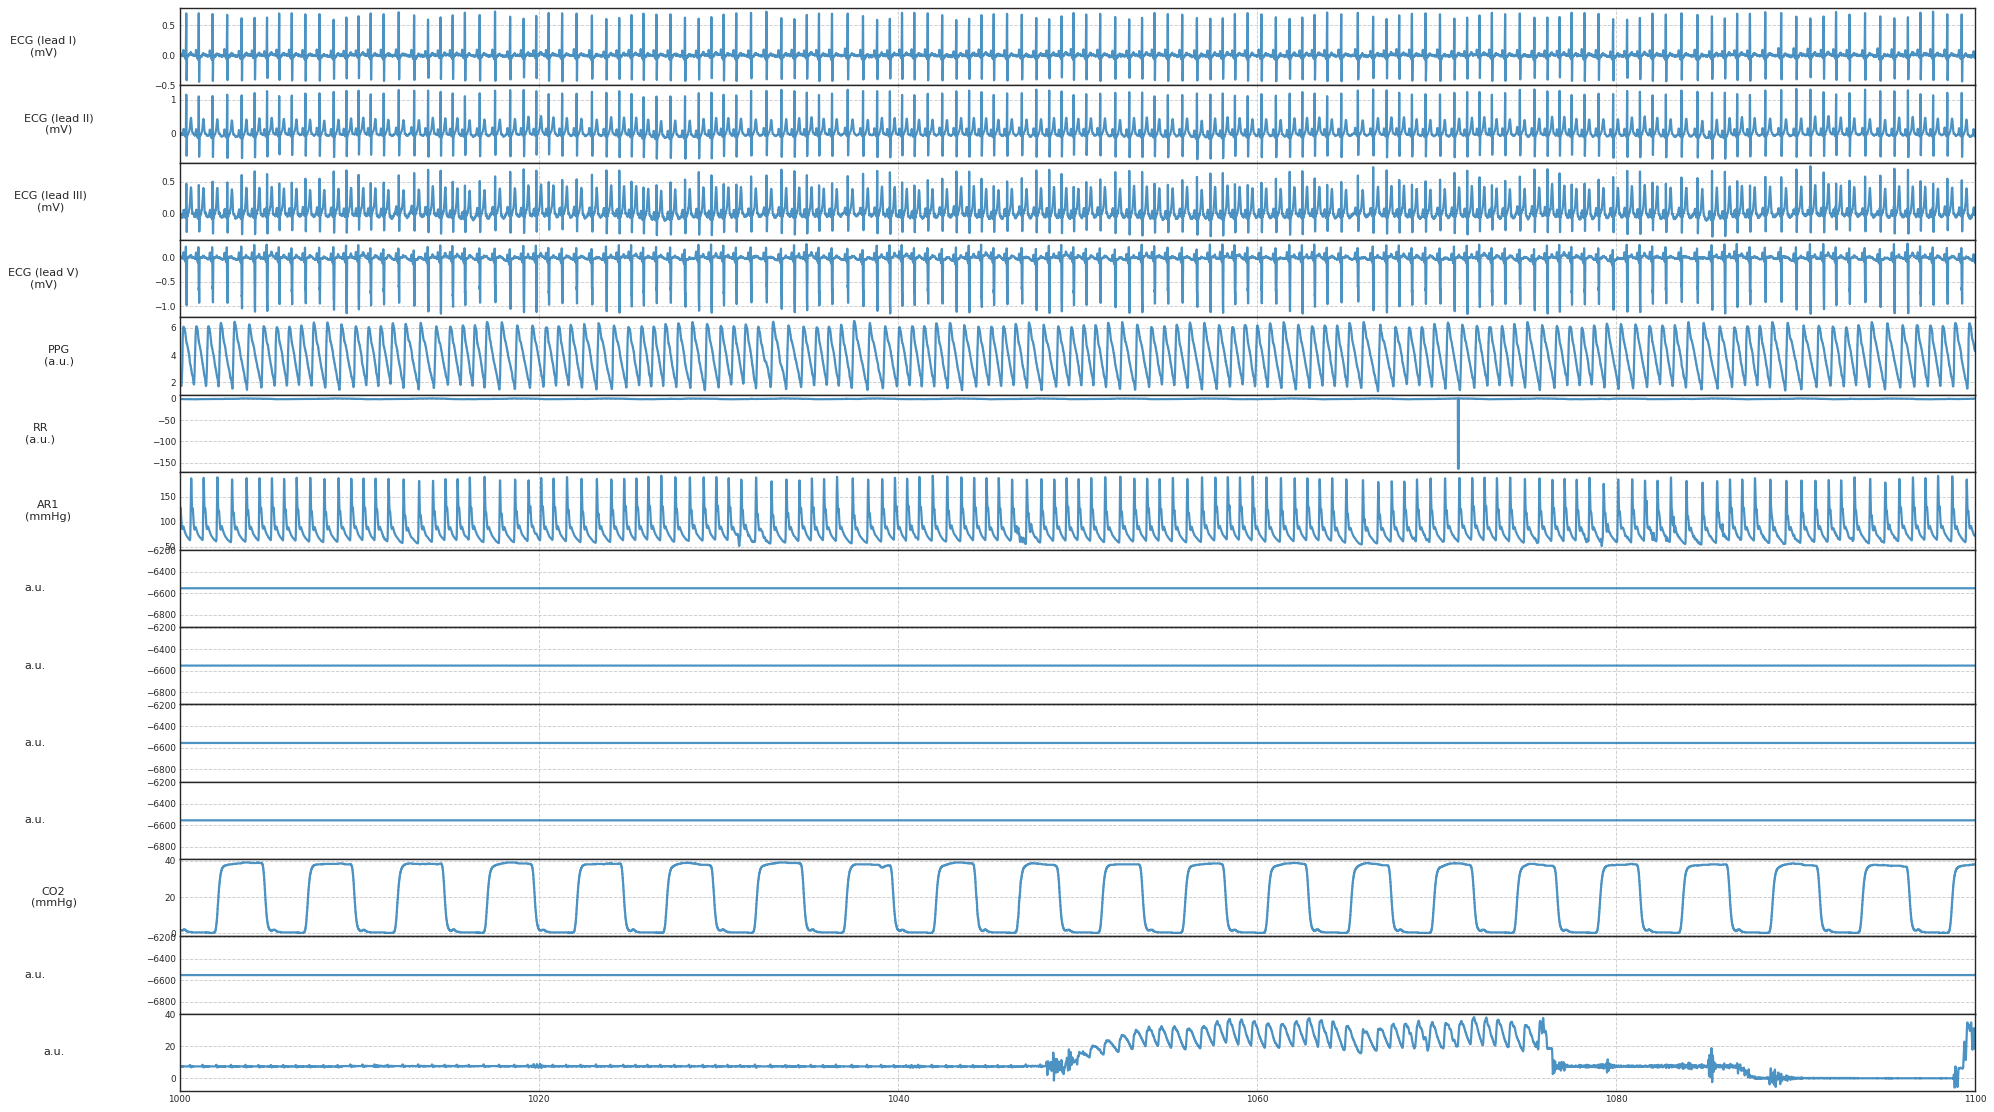

In [57]:
plot_all_sync(df, subject_id, plotted_sigs, unit_dict, fig_name=None, outputdir=None, show_plot=True)


# signal level functions

In [ ]:
def get_ecg_IP_norm(ecg1, ecg2):
    return (ecg1 @ ecg2) / ((ecg1 @ ecg1)**0.5 * (ecg2 @ ecg2)**0.5)



# signal to beats

In [ ]:
def segment_df(df_seg, QRS_detector_dict, Fs):
    
    df = get_filt_df(df_seg, Fs).copy()
    
    
    ecg_dict = QRS_detector_dict['ecg_dict']
    i_R_peaks = QRS_detector_dict['i_R_peaks']
#     i_R_peaks = QRS_detector_dict['i_R_peaks']
    # end_offset = QRS_detector_dict['end_offset']
    end_offset = int(1*Fs)
    # print(end_offset)
    # sys.exit()
    
    beats_dict = {}
    

    for sig_name in df.columns:
        if sig_name =='time':
            continue
        if sig_name =='RR':
            continue
        sig_beats, i_R_peaks_used = beat_segmentation(df[sig_name].values, i_R_peaks, start_offset=0, end_offset=end_offset)
        beats_dict[sig_name] = sig_beats
        
        
    sig_beats, i_R_peaks_used = beat_segmentation(df_seg['SPO2'].values, i_R_peaks, start_offset=0, end_offset=end_offset)
    beats_dict['PPG_DC'] = sig_beats

    beats_dict['i_R_peaks'] = i_R_peaks_used
    
    return beats_dict

# feature level functions

In [ ]:
def get_B2C(sig,beat_deriv1, beat_deriv2, Fs):
    N_window = int(0.15*Fs)
    i_min, i_derivmax, i_foot, data_derivmax, data_min = PPG_argfoot(sig, fs=Fs)
    # np.argmin(np.abs(beat_deriv1[i_min-N_window:i_min+N_window]))
    # i_foot = i_max-N_window

    i_min = i_min[0]

    i_A = np.argmax(beat_deriv2[i_min:i_min+int(0.1*Fs)])
    i_A += i_min

    i_B = np.argmin(beat_deriv2[i_A:i_A+int(0.2*Fs)])
    i_B += i_A

    i_C = np.argmax(beat_deriv2[i_B:i_B+int(0.2*Fs)])
    i_C += i_B

    i_D = np.argmin(beat_deriv2[i_C:i_C+int(0.2*Fs)])
    i_D += i_C

    amplitude_A = np.abs(beat_deriv2[i_A])
    amplitude_B = np.abs(beat_deriv2[i_B])
    amplitude_C = np.abs(beat_deriv2[i_C])
    amplitude_D = np.abs(beat_deriv2[i_D])


    feature_B2C = amplitude_B/amplitude_C
    
    output_dict = {
    'i_min': i_min,
    'i_A': i_A,
    'i_B': i_B,
    'i_C': i_C,
    'i_D': i_D,
    'amplitude_A': amplitude_A,
    'amplitude_B': amplitude_B,
    'amplitude_C': amplitude_C,
    'amplitude_D': amplitude_D,
    'feature_B2C': feature_B2C,
    }
    
    return output_dict

def debug_B2C(beats_PPG, Fs):
    k = 20
    sig= beats_PPG[:,[k]]
    dx = 1/Fs

    beat_deriv1 = np.gradient(sig.squeeze(), dx)
    beat_deriv2 = np.gradient(np.gradient(sig.squeeze(), dx), dx)

    output_dict = get_B2C(sig, beat_deriv1, beat_deriv2, Fs)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,5), dpi=100)

    ax1.plot(t_beat, beats[:,k], color='gray', alpha=1)
    ax1.set_ylabel('PPG')
    ax2.plot(t_beat, beat_deriv1, color='gray', alpha=1)
    ax2.set_ylabel('PPG 1st derivative')

    ax3.plot(t_beat, beat_deriv2, color='gray', alpha=1)

    ax3.scatter(output_dict['i_min']/Fs, beat_deriv2[output_dict['i_min']])
    ax3.scatter(output_dict['i_A']/Fs, beat_deriv2[output_dict['i_A']], color='r')
    ax3.scatter(output_dict['i_B']/Fs, beat_deriv2[output_dict['i_B']], color='g')
    ax3.scatter(output_dict['i_C']/Fs, beat_deriv2[output_dict['i_C']], color='k')
    ax3.scatter(output_dict['i_D']/Fs, beat_deriv2[output_dict['i_D']], color='y')
    ax3.set_ylabel('PPG 2nd derivative')

    
def get_max2min(sig):

    feature_max2min = sig.max()-sig.min()

    output_dict = {
        'feature_max2min': feature_max2min
    }

    return output_dict

def get_PI(feature_max2min, sig_DC):
    
    featrue_PI = feature_max2min/sig_DC.mean()
    
    output_dict = {
        'featrue_PI': featrue_PI
    }
    
    return output_dict


def get_std(sig):
    return np.std(sig)

def get_skewness(sig):
    return scipy.stats.skew(sig)[0]

def get_kurtosis(sig):
    return scipy.stats.kurtosis(sig)[0]

def get_energy(sig):
    return np.sum((sig-sig.mean())**2)

def get_rms(sig):
    return np.sqrt(np.mean(sig**2))

def get_mean(sig_DC):
    return np.mean(sig_DC)


# master beat2features function

In [ ]:
def beat2features(beats_dict, Fs):

    beats_PPG = beats_dict['SPO2']
    beats_PPG_DC = beats_dict['PPG_DC']
    i_R_peaks = beats_dict['i_R_peaks']
    dx = 1/Fs

    df_features = pd.DataFrame()

    for k in range(beats_PPG.shape[1]):
        # print(k)
        sig = beats_PPG[:,[k]]
        sig_DC = beats_PPG_DC[:,[k]]
        i_R_peak = i_R_peaks[k]

        beat_deriv1 = np.gradient(sig.squeeze(), dx)
        beat_deriv2 = np.gradient(np.gradient(sig.squeeze(), dx), dx)

        feature_B2C = get_B2C(sig, beat_deriv1, beat_deriv2, Fs)['feature_B2C']
        feature_max2min = get_max2min(sig)['feature_max2min']
        featrue_PI = get_PI(feature_max2min, sig_DC)['featrue_PI']



        # features that use cardiac PPG (filtered between 0.8-4Hz)
        feature_std = get_std(sig)
        feature_skewness = get_skewness(sig)
        feature_kurtosis = get_kurtosis(sig)
        feature_rms = get_rms(sig)
        feature_energy = get_energy(sig)


        # features that use raw PPG
        feature_mean = get_mean(sig_DC)


        df_beat = pd.DataFrame({
            'i_R_peak': [i_R_peak],
            'B2C': [feature_B2C],
            'max2min': [feature_max2min],
            'PI': [featrue_PI],
            'std': [feature_std],
            'skewness': [feature_skewness],
            'kurtosis': [feature_kurtosis],
            'rms': [feature_rms],
            'energy': [feature_energy],
            'mean': [feature_mean],
        })

        df_features = pd.concat([df_features, df_beat])

        # df_features = df_features.append(df_beat)

    return df_features


In [ ]:
def get_FQI_dict(data):

    data_median = medfilt(data, k=9)

    data_deviation = np.abs(data - data_median)

    mask_feature = data_deviation < data_deviation.std()*3

    data_deviation_normed = (data_deviation-data_deviation.min()) / (data_deviation.max()-data_deviation.min())

    FQI = np.exp(-0.5*data_deviation_normed)

    FQI_dict = {
        'data_deviation': data_deviation,
        'mask_feature': mask_feature,
        'FQI': FQI,
    }
    return FQI_dict

# feature level qaulity assessment

In [ ]:
def get_mask_all(df_features):

    mask_feature_list = []
    for feature_name in df_features.columns:
        if feature_name == 'i_R_peak':
            continue

        FQI_dict = get_FQI_dict(df_features['B2C'].values)
        mask_feature = FQI_dict['mask_feature']
        mask_feature_list.append(mask_feature)
        # print(feature_name)

    mask_feature_list = np.stack(mask_feature_list).T
    mask_feature_list = np.prod(mask_feature_list, axis=1)
    mask_feature_list = mask_feature_list==1
    return mask_feature_list

In [ ]:
def masking_beats_dict(beats_dict, mask):

    # print(beats_dict['AR1'].shape)
    for beat_name in beats_dict.keys():
        if beat_name == 'i_R_peaks':
            beats_dict[beat_name] = beats_dict[beat_name][mask]
        else:
            beats_dict[beat_name] = beats_dict[beat_name][:, mask]

    # print(beats_dict['AR1'].shape)

    return beats_dict

In [ ]:

# seg_duration = 1 * 60 * 60 # seconds
seg_duration = 30 * 60 # seconds
print('seg_duration is {} sec'.format(seg_duration))
N_segs = int((df.shape[0]/Fs)//seg_duration)

df_features_sub = pd.DataFrame()

for i_seg in range(N_segs):
    
    print('i_seg: ', i_seg)

    # if i_seg != 5:
    #     continue
    i_start = i_seg*seg_duration*Fs
    i_end = (i_seg+1)*seg_duration*Fs

    df_seg = df[i_start:i_end]
    
    if df_seg.shape[0]==0:
        continue
    
    norm1 = np.abs(get_ecg_IP_norm(df_seg['I'].values, df_seg['II']))
    norm2 = np.abs(get_ecg_IP_norm(df_seg['I'].values, df_seg['III']))
    norm3 = np.abs(get_ecg_IP_norm(df_seg['I'].values, df_seg['V']))

    if (norm1 < 0.3) or (norm2 < 0.3) or (norm3 < 0.3):
        print('\tbad ECG')
        continue
    

    sig_name = 'I'
    ECG = df_seg[sig_name].values
    
    
    # ECG = df[sig_name].values

    fig_name = 'ECG_diagnostics_'+sig_name
    # QRS_detector_dict = task_HR_detector(ECG, Fs, fig_name=fig_name, outputdir=None, show_plot=True)
    QRS_detector_dict = task_HR_detector(ECG, Fs, fig_name=fig_name, outputdir=None, show_plot=False)

#     t_ecg = np.arange(ECG.shape[0])/Fs
#     hr_interp = np.interp(t_ecg, QRS_detector_dict['ts_hr'], QRS_detector_dict['hr'])


    # segment the beats
    beats_dict = segment_df(df_seg, QRS_detector_dict, Fs)
    mask_ppg, ol_rate = clean_PPG(beats_dict['SPO2'], beats_dict['SPO2'].mean(axis=1), Fs)
    beats_dict = masking_beats_dict(beats_dict, mask_ppg)

    if ol_rate > 0.1:
        print('\tbad PPG')
        continue
    print('\t\tPPG outlier rate: {:.2f}%'.format( ol_rate*100) )
    # sys.exit()
        

    # sys.exit()
    
    print('\t\tpass ECG and PPG SQI tests...')

    
    beats_dict['i_R_peaks'] = beats_dict['i_R_peaks'] + i_start    

    # ensemble the beats (N=4)
    use_ensemble = True
    
    if use_ensemble:
        for key in beats_dict:
            if 'ppg' not in key:
                continue
            sig_beats = beats_dict[key]
            beats_dict[key] = get_ensemble_beats(sig_beats, N_enBeats=4, use_woody=False)
            
            
    df_features = beat2features(beats_dict, Fs)
    
    # reject unnecessary features
    mask_all = get_mask_all(df_features)
    # sys.exit()
    print('\t\tfaeture rejection rate: {:.2f}%'.format( 100-mask_all.mean()*100) )
    df_features = df_features.loc[mask_all, :].copy()
    
    df_features_sub = pd.concat([df_features_sub, df_features])

print('done')

In [ ]:
if df_features_sub.shape[0]!=0:
    
    outputdir_recording = outputdir+recording_name+'/'
    if not os.path.exists(outputdir_recording):
        os.makedirs(outputdir_recording)
        

    df_features_sub.to_csv(outputdir_recording+'df_features_sub.csv.gz', index=False, compression='gzip')
    df = pd.read_csv(outputdir_recording+'df_features_sub.csv.gz', compression='gzip')
    print(df)

In [ ]:
sys.exit()

In [ ]:
beats = beats_dict['SPO2']

plt.plot(beats, color='gray', alpha=0.1)
plt.plot(beats.mean(axis=1), color='red', alpha=0.7)
# plt.ylim(-1,1)
plt.show()

beats = beats_dict['SPO2'][:, mask_all]

plt.plot(beats, color='gray', alpha=0.1)
plt.plot(beats.mean(axis=1), color='red', alpha=0.7)
# plt.ylim(-1,1)
plt.show()

In [ ]:
feature_names = list(df_features_sub.keys())
feature_names.remove('i_R_peak')


# feature_names

In [ ]:
# sns.set_theme(style="whitegrid")
# tips = sns.load_dataset("tips")

fig, axes = plt.subplots(len(feature_names),1, figsize=(5,20), dpi=80)

for ax, feature_name in zip(axes, feature_names):
# sns.violinplot(x=df_features["B2C"], ax=axes[0], orient='v')
# sns.violinplot(x=df_features["PI"], ax=axes[1], orient='v')

    sns.violinplot(data=df_features_sub, y=feature_name, ax=ax)
# sns.violinplot(data=df_features_sub, y="PI", ax=axes[1])


In [ ]:
df_features_sub.keys()

In [ ]:
plt.plot(df_features_sub['rms'].values)

In [ ]:
np.median(df_features_sub['max2min'].values)

In [ ]:

# np.prod(mask_feature_list, axis=1)

In [ ]:
mask_feature_list.shape

In [ ]:
aaa = np.asarray([[ True,  True,  True, True],
       [ True,  False,  True, True],
       [ True,  True,  True, True]])

aaa

In [ ]:
np.prod(aaa, axis=1)

In [ ]:
mask_feature_list.shape

In [ ]:
# np.stack(mask_feature_list).T
# aaa = np.asarray([[1.,2.],[3.,4.]])
# np.prod(aaa, axis=0), aaa

In [ ]:
FQI_dict

In [ ]:
FQI_dict = get_FQI_dict(df_features['B2C'].values)
plt.plot(FQI_dict['FQI'])

In [ ]:
plt.plot(ECG)
plt.xlim(0,1000)

In [ ]:
t_ecg = np.arange(ECG.shape[0])/Fs
hr_interp = np.interp(t_ecg, QRS_detector_dict['ts_hr'], QRS_detector_dict['hr'])

# plt.plot(t_ecg, hr_interp)
plt.plot(QRS_detector_dict['ts_hr'], QRS_detector_dict['hr'])
plt.xlim(0, 100)

In [ ]:
# plt.plot(t_ecg, ECG)
# plt.xlim(0, 500)

In [ ]:
# plt.plot(t_ecg, ECG)
# plt.xlim(300, 350)

In [ ]:
# plt.plot(t_ecg[::10], hr_interp[::10])
# plt.xlim(0, 1000)

In [ ]:
# def get_filt_df(df_sync, Fs):
#     df = df_sync.copy()

#     for sig_name in df.columns:
#         if 'I' == sig_name or 'II' == sig_name or 'III' == sig_name or 'V' == sig_name:
#             df[sig_name] = get_padded_filt(df[sig_name].values, filter_padded=1, lowcutoff=FILT_ECG[0], highcutoff=FILT_ECG[1], Fs=Fs)
#         elif 'RR' == sig_name:
#             df[sig_name] = get_padded_filt_DSwrapper(df[sig_name].values, filter_padded=1, lowcutoff=FILT_RESP[0], highcutoff=FILT_RESP[1], Fs=Fs)
#         elif 'SPO2' == sig_name:
#             df[sig_name] = get_padded_filt(df[sig_name].values, filter_padded=1, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=Fs)
#         else:
#             pass

#     return df


In [ ]:

# beats_dict = segment_df(df_seg, QRS_detector_dict, Fs)
# use_ensemble = True


In [ ]:
# if use_ensemble:
#     for key in beats_dict:
#         if 'ppg' not in key:
#             continue
#         sig_beats = beats_dict[key]
#         beats_dict[key] = get_ensemble_beats(sig_beats, N_enBeats=4, use_woody=False)

In [ ]:
beats_dict.keys()

In [ ]:
beats_id = [1,2,3,4,5,6]
beats_names = ['I', 'II', 'III', 'V', 'SPO2', 'PPG_DC']
unit_dict['PPG_DC'] = ''

def plot_ALL_beats(beats_dict, beats_id, subject_id, Fs, show_good=None, fig_name=None, outputdir=None, show_plot=False):

    t_beat = np.arange(beats_dict['I'].shape[0])/Fs

    fig = plt.figure(figsize=(16, 10), dpi=80)
    fontsize = 20
    alpha = 0.03


    # for (beat_name, beat_i) in zip(beats_dict, beats_id):
    for (beat_name, beat_i) in zip(beats_names, beats_id):

        beats = beats_dict[beat_name]

        ax = fig.add_subplot(3, 4, beat_i)
        ax.set_title(beat_name+'\n', fontsize=fontsize)

        show_good = True
        if show_good is not None:


            template = beats_dict[beat_name].mean(axis=1)
            if beat_name=='SPO2':
                mask_all, ol_rate = clean_PPG(beats, template, Fs)
                ax.set_title(beat_name+'\nacception_rate:{:.2f}'.format(1-ol_rate), fontsize=fontsize)

            # if 'ppg' in beat_name:

    #             # if beat_name[-1]=='1':
    #                 template = beats_dict['ppg_r_1'].mean(axis=1)
    #             elif beat_name[-1]=='2':
    #                 template = beats_dict['ppg_r_1'].mean(axis=1)

    #             mask_all, ol_rate = clean_PPG(beats, template, Fs)
    #             if show_good==False:
    #                 beats = beats[:, ~mask_all]
    # #                     print(beat_name, ol_rate)
    #                 ax.set_title(beat_name+'\nrejection_rate:{:.2f}'.format(ol_rate), fontsize=fontsize)
    #             else:
    #                 beats = beats[:, mask_all]
    # #                     print(beat_name, ol_rate)
    #                 ax.set_title(beat_name+'\nacception_rate:{:.2f}'.format(1-ol_rate), fontsize=fontsize)



        ax.plot(t_beat, beats, color='gray', alpha=alpha)
        ax.plot(t_beat, np.mean(beats,axis=1), color='firebrick', linewidth=3)

        if 'SPO2' in beat_name or 'I' == beat_name or 'II' == beat_name or 'III' == beat_name or 'V' == beat_name:
            beats_mean = np.mean(beats,axis=1)

            ymin = beats_mean.mean() - beats_mean.std()*5
            ymax = beats_mean.mean() + beats_mean.std()*5
            ax.set_ylim(ymin, ymax)

        ax.tick_params(axis='both', which='major', labelsize=13)
        ax.set_ylabel(unit_dict[beat_name], fontsize=fontsize-3)
        ax.set_xlabel('time (sec)', fontsize=fontsize)



    fig.tight_layout()

    # if outputdir is not None:

    #     if fig_name is None:
    #         fig_name = 'beats_ensemble_sub{}'.format(subject_id)

    #     if not os.path.exists(outputdir):
    #         os.makedirs(outputdir)
    #     fig.savefig(outputdir + fig_name+'.png', transparent=False)

    # if show_plot == False:
    #     plt.close(fig)
    #     pyplot.close(fig)
    #     plt.close('all')


    # #     if log_wandb:
    # #         wandb.log({fig_name: wandb.Image(fig)})



In [ ]:
df_features

In [ ]:
plt.plot(df_features['PI'].values)

In [ ]:
debug_B2C(beats_PPG, Fs)


In [ ]:
data = df_features['B2C'].values
FQI_dict = get_FQI_dict(data)
plt.plot(FQI_dict['FQI'])

In [ ]:
df_features

In [ ]:
data = df_features['PI'].values
FQI_dict = get_FQI_dict(data)
plt.plot(FQI_dict['FQI'])

In [ ]:
data = df_features['max2min'].values
FQI_dict = get_FQI_dict(data)
plt.plot(FQI_dict['FQI'])

In [ ]:
feature_names!='i_R_peak'

In [ ]:
feature_names

In [ ]:
feature_names = df_features.columns
feature_names = feature_names[feature_names!='i_R_peak']
N_feature = feature_names.shape[0]

In [ ]:
df_seg

In [ ]:
fig, (axes) = plt.subplots(N_feature+2, 1, figsize=(20,8), dpi=100)

t_sig = df_seg['time'].values
t_sig = t_sig-t_sig[0]

ax1= axes[0]
ax1.plot(t_sig, df_seg['SPO2'].values)
ax1.set_ylabel('PPG')

ax2= axes[1]
ax2.plot(t_sig, df_seg['RR'].values)
ax2.set_ylabel('RR')

for i, feature_name in enumerate(feature_names):
    ax = axes[i+2]
    # ax2.scatter(beats_dict['i_R_peaks'][mask_feature], features_B2C[mask_feature])
    data = df_features[feature_name].values
    FQI_dict = get_FQI_dict(data)
    mask_feature = FQI_dict['mask_feature']
    ax.plot(df_features['i_R_peak'][mask_feature&mask_all]/Fs, df_features[feature_name][mask_feature&mask_all])
    ax.scatter(df_features['i_R_peak'][mask_feature&mask_all]/Fs, df_features[feature_name][mask_feature&mask_all])
    ax.set_ylabel(feature_name)

ax.set_xlabel('time (s)')
fig.tight_layout()


In [ ]:
beats_dict['i_R_peaks'].shape, features_B2C.shape

In [ ]:
sig_plt

In [ ]:
t_start = 1100
t_end = 1150

df_seg = df[(df['time']>=t_start) & (df['time']<=t_end)].copy()

t_arr = df_seg['time'].values
#     t_arr = t_arr - t_arr[0]

t_start = t_arr[0]
t_end = t_arr[-1]

sig_name = 'SPO2'
sig_plt = df_seg[sig_name].values


sig_plt = get_padded_filt(sig_plt, filter_padded=5, lowcutoff=1, highcutoff=4, Fs=Fs)

# t_arr = df_seg['time'].values
alpha=0.5
fig, ax = plt.subplots(1, 1, figsize=(25,10), gridspec_kw = {'wspace':0, 'hspace':0}, dpi=80)
ax.plot(t_arr, sig_plt, alpha=alpha ,zorder=1, linewidth=linewidth)
# ax.set_ylim(-5,5)

In [ ]:
unit_dict

In [ ]:
homedir = os.path.expanduser('~')+'/'

In [ ]:
inputdir = homedir+'kamaleswaranlab/Sepsis3_062321/Files_cp_sftp_6_30_21/Files_cp_6_30_21/'

In [ ]:
for sub_file in os.listdir(inputdir):
    # print(sub_file)
    pass

In [ ]:
sub_id = 'A071-0512777549'

In [ ]:
for sub_file in os.listdir(inputdir+sub_id):
    if 'hea' in sub_file:
        print(sub_file)